## Correlation plot


In [1]:
# KHOA NOTE: Remove #4
usedSubjects=[1,2,3,4,5,6,7,8,9,10,11,12,13,16,19,20]
subjectID=8
subjectID=subjectID-1

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.io



def readCSV(fileName):
    res=np.array(pd.read_csv(fileName,header=None,delimiter='\t'))
    return res

def readTXT(fileName):
    res=np.array(pd.read_csv(fileName,header=None,delimiter='\t'))
    return res

noSubjectNum=0
# for i in range(noSubjectNum):
i=subjectID
Fn=f"OK00{i+1}" if i < 9 else f"OK0{i+1}"
print(Fn)


GaitPodFn=Fn+"_vel_imu.mat"
HRFn=Fn+"_HR.csv"
oxygenFn=Fn+"_Oxycon.txt"
print(GaitPodFn)


HR_dir="HR data/"
oxygen_dir="OxyCon data/"
gaitpod_dir="GaitPod data/"


HRFn=HR_dir+HRFn
oxygenFn=oxygen_dir+oxygenFn
GaitPodFn=gaitpod_dir+GaitPodFn

OK008
OK008_vel_imu.mat


## Define cutoff time

In [3]:
# -1 cutoff time means NaN
# cut-off times based on measurement memos (in seconds)
GaitPod_CutOff_Times = [565, 358, 318, 672, 700, 660, 594, 280, 533, 365, 474, 1549, 530, -1, -1, 387, -1, -1, 375, 350];
# cut-off times based on cross-correlation of normalized VO2 and HR data (in seconds)
HR_CutOff_Times = [519, 521, 409, 505, 450, 502, 490, 430, 528, 546, 365, 712, 401, -1, -1, 390, -1, -1, 387, 410];

## Define resampling time 

In [4]:
# Sampling time for heart rate (in seconds)
HR_sampling_time=5

# Sampling time for oxygen (in seconds)
Oxygen_sampling_time=5

# Sampling time for gaitpod (in seconds)
GaitPod_sampling_time=5

In [5]:
oxygen_data=np.array(np.squeeze(pd.read_csv(oxygenFn,header=6,delimiter='\t')))
oxygen_data_reconstruct=np.zeros(np.shape(oxygen_data))

# Define a custom function to convert string with comma to float
iter = 1

def check_duplicates(arr):
    unique_values, counts = np.unique(arr,return_counts=1)
    duplicated_vaules = unique_values[counts>1]
    print(duplicated_vaules)
    for duplicate in duplicated_vaules:
        indices = np.where(arr == duplicate)[0]
        print(f"Element {duplicate} is duplicated at indices: {indices.tolist()}")

def comma_to_float(string):
    string=str(string)
    if len(string) == 0 or '-' in string:
        return -100
    # Replace comma with dot and convert to float
    if ',' in string:
        return np.float32(string.replace(',', '.'))
    else:
        return np.float32(string)

def remove_outline(array,outline_threshold):
    for i,row in enumerate(array):
        if row[1]>outline_threshold:
            print(f"Delete outline at it {i}")
            np.delete(array,i,0)
    return array


oxygen_data_reconstruct=np.zeros(np.shape(oxygen_data))
iter=0

for row in oxygen_data:
    oxygen_data_reconstruct[iter][0]=row[0]
    oxygen_data_reconstruct[iter][1]=comma_to_float(row[1])
    iter+=1
    
oxygen_data_reconstruct=np.array(oxygen_data_reconstruct)

print(oxygen_data_reconstruct[:,0])


# plt.figure(figsize=(17.5,15))
# plt.plot(oxygen_data_reconstruct[:,1])
# print(np.shape(oxygen_data_reconstruct))


outline_threshold=200
for i,row in enumerate(oxygen_data_reconstruct):
    if row[1]>outline_threshold:
#         print(f"Delete outline at it {i}")
        oxygen_data_reconstruct=np.delete(oxygen_data_reconstruct,i,0)

## REMOVE MISSING DATA
mask=oxygen_data_reconstruct[:, 1] >= 0
oxygen_data_reconstruct=oxygen_data_reconstruct[mask]

## OXYGEN IS RECORDED AT AVERAGE OF 3 seconds
timestamps=oxygen_data_reconstruct[:,0]
print(timestamps)
firstSec=timestamps[0]
lastSec=timestamps[-1]

## DO WE NEED SAMPLING FOR 3SECONDS ?? IT WILL RESULT IN 2 MISSING DATA INTERVALS
oxygenResamplingIdx = np.arange(firstSec, lastSec, Oxygen_sampling_time)
oxygen_sampling=np.interp(oxygenResamplingIdx,timestamps,oxygen_data_reconstruct[:,1])

# plt.plot(oxygen_sampling)

[  25.   30.   35. ... 5198. 5201. 5205.]
[  25.   30.   35. ... 5198. 5201. 5205.]


## Heart rate processing


430
0.0
7533.254


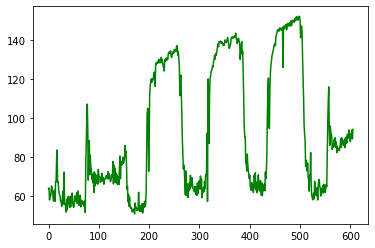

In [6]:
HR_CutOff_Time=HR_CutOff_Times[subjectID]
print(HR_CutOff_Time)
HR_data=np.squeeze(readCSV(HRFn))
# HR_data=np.char.split(np.squeeze(readCSV(HRFn)),sep=";")
HR_data_stack=list()
for i in range(len(HR_data)):
    HR_data_tmp=HR_data[i].split(";")
#     print(HR_data_tmp)
    HR_data_stack.append(HR_data_tmp)
HR_data_stack=np.vstack(HR_data_stack)


## Remove HR data with len=0
arr_list=HR_data_stack.tolist()
HR_data_stack=[item for item in arr_list if len(item[0]) > 0 and len(item[1]) > 0]
HR_data_stack=np.array(HR_data_stack).astype(np.float32).squeeze()

# plt.figure(figsize=(17.5,15))
HR_data_stack[:,0]=HR_data_stack[:,0]/1000
# plt.plot(HR_data_stack[:,0],HR_data_stack[:,1])
# print(np.shape(HR_data_stack))

HRFirstEle=HR_data_stack[0,0]
HRLastEle=HR_data_stack[-1,0]
print(HRFirstEle)
print(HRLastEle)
HR_sampling_index=np.arange(firstSec, lastSec, HR_sampling_time)

HR_sampling=np.interp(HR_sampling_index,HR_data_stack[:,0],HR_data_stack[:,1])

##=========== Cut off HR data
HR_sampling_cut=HR_sampling[HR_CutOff_Time:]
# plt.plot(HR_sampling)
# plt.plot(np.diff(HR_data_stack[:,0]))
# plt.plot(HR_data_stack[:,1],'r')
plt.plot(HR_sampling_cut,'g')


## Gaitpod processing

In [7]:
gaitpod_data = scipy.io.loadmat(GaitPodFn)

v_lon=gaitpod_data['V_lon']
v_d=gaitpod_data['v_d']


gaitpod_CutOff_Time=GaitPod_CutOff_Times[subjectID]
print(np.shape(v_lon))
gp_new_idx=gaitpod_CutOff_Time*400

print(np.isnan(v_d).any())
print(np.isnan(v_lon).any())

v_lon=v_lon[gp_new_idx:,:]

v_d=v_d[~np.isnan(v_d)]

N=len(v_lon)
idx=np.arange(0,N,400*GaitPod_sampling_time)
print(len(idx))
v_lon_match=np.zeros_like(idx)
v_d_match=np.zeros_like(idx)

v_lon_match = pd.DataFrame(v_lon)

v_lon_match = v_lon_match.rolling(400).mean()
    
for i in range(len(idx)-1):
    v_d_match[i]=np.mean(v_d[idx[i]:idx[i+1]-1])

(2222246, 1)
False
False
1056


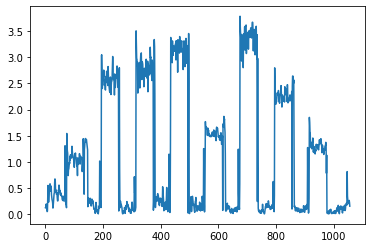

In [8]:
plt.plot(v_lon_match.iloc[idx].values)
v_lon_match=v_lon_match.iloc[idx].values

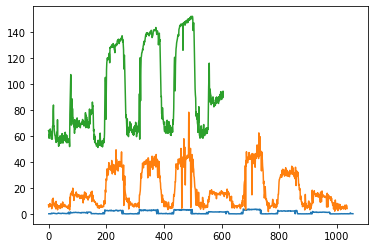

In [9]:
plt.plot(v_lon_match)
plt.plot(oxygen_sampling)
plt.plot(HR_sampling_cut)


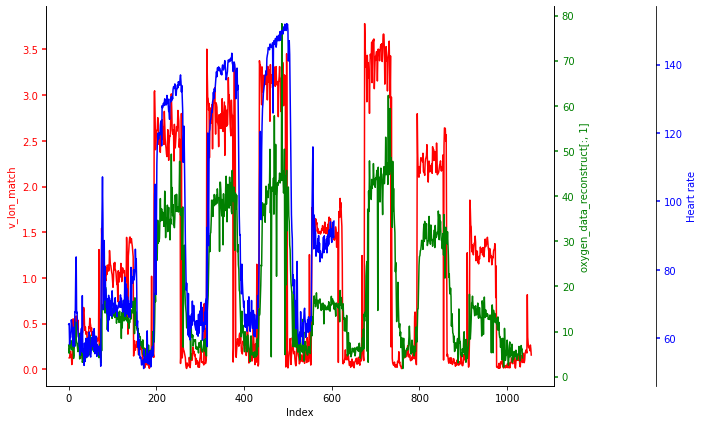

In [10]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
fig, ax1 = plt.subplots(figsize=(10, 6))


ax2 = ax1.twinx()
ax3 = ax1.twinx()


##============ PLOT 3 DATAS
p1, = ax1.plot(v_lon_match, 'r', label='v_lon_match')
# p2, =ax2.plot(oxygen_data_reconstruct[:, 1], 'g', label='oxygen_data')
p2, =ax2.plot(oxygen_sampling,'g',label='oxygen_sampling_5s')
p3,=ax3.plot(HR_sampling_cut, 'b', label='HR_sampling')


ax1.set_xlabel('Index')
ax1.set_ylabel('v_lon_match', color='r')
ax1.yaxis.label.set_color(p1.get_color())

# Create the second plot with secondary y-axis
ax2.set_ylabel('oxygen_data_reconstruct[:, 1]', color='g')
ax2.yaxis.label.set_color(p2.get_color())


# Create the third plot with additional y-axis on the right side
ax3.spines["right"].set_position(("axes", 1.2))
make_patch_spines_invisible(ax3)
ax3.spines["right"].set_visible(True)
ax3.set_ylabel('Heart rate')
ax3.yaxis.label.set_color(p3.get_color())
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position('right')


# Adjust spacing between subplots
fig.tight_layout()

# Display the legend
# handles1, labels1 = ax1.get_legend_handles_labels()
# handles2, labels2 = ax2.get_legend_handles_labels()
# handles3, labels3 = ax3.get_legend_handles_labels()
# plt.legend(handles1 + handles2 + handles3, labels1 + labels2 + labels3)

# Remove the top index axis
# ax1.tick_params(axis='x', top=False)

tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='y',colors=p1.get_color(),**tkw)
ax2.tick_params(axis='y',colors=p2.get_color(),**tkw)
ax3.tick_params(axis='y',colors=p3.get_color(),**tkw)

ax1.spines[['top']].set_visible(False)
ax2.spines[['top']].set_visible(False)
ax3.spines[['top']].set_visible(False)

# Show the plot
plt.show()


## Calculate steps then speed, speed change, step duration and vertical oscillation distance amplitude

## Calculate correlation

In [11]:

min_len=min(len(v_lon_match),len(oxygen_sampling),len(HR_sampling))
v_lon_match=v_lon_match[:min_len]
oxygen_sampling=oxygen_sampling[:min_len]
HR_sampling=HR_sampling[:min_len]

# print(np.shape(v_lon_match))
# print(np.shape(oxygen_sampling))
# print(np.shape(HR_sampling))

data_frame=pd.DataFrame({"Longitudinal_Velocity":v_lon_match,"Oxygen":oxygen_sampling,"Heart_Rate":HR_sampling})
print(data_frame)

ValueError: Per-column arrays must each be 1-dimensional

## Plot 2 outlined points

In [ ]:
a=resStack[:,0:2]
b=a[abs(a[:,0]-a[:,1])>20]
print(b)
diff=b[:,0]-b[:,1]
print(diff)
c=np.mean([b[:,0],b[:,1]],axis=0)
print(c)

plt.figure(figsize=(3,2.8))
#plt.subplot(2,1,1)
plt.scatter(c[0],diff[0],color="green")
#plt.xlim(18.5,19)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)

plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)


fig = plt.gcf()
fig.savefig('dots1'+'.jpg',bbox_inches='tight')
#plt.subplot(2,1,2)
plt.show()



In [ ]:
plt.figure(figsize=(3.0,2.8))
plt.scatter(c[1],diff[1],color="orange")
#plt.xlim(15,25)
#plt.ylim(-25,-30)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)

plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

fig = plt.gcf()
fig.savefig('dots2'+'.jpg',bbox_inches='tight')
plt.show()

## Save the final figure

In [ ]:
from PIL import Image, ImageDraw, ImageFilter
bigIm=Image.open('BlandAltman_all_subjects.jpg')
dot1=Image.open('dots1.jpg')
dot2=Image.open('dots2.jpg')

back_im = bigIm.copy()
back_im.paste(dot1,(180,750))
back_im.paste(dot2,(180,150))
#back_im.show()
back_im.save('final.jpg',qualit=95)

## References plot from built-in library

In [ ]:
import statsmodels.api as sm
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(VO2_hat,VO2,ax=ax)
plt.show()
#print(mean)